In [1]:
%%time
# Python 2.7

%matplotlib nbagg
%matplotlib inline 

import sys
sys.path
sys.path.append('..')
print(sys.version)

import os
import cPickle 
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne 
import lasagne.layers as L
import parmesan
import cPickle as pickle

from sklearn.utils import shuffle

import tools as tls


from data_loaders import svhn



/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5105)


CPU times: user 1.92 s, sys: 1.22 s, total: 3.14 s
Wall time: 6.56 s


In [2]:
### GLOBAL PARAMETERS ###

### META - HOW THE PROGRAM WORKS
file_name = 'data_no_share_c3' # assumes '.pkl'
np.random.seed(1234) # reproducibility

### CONSTANTS
IMG_LEN = 32
IMG_DEPTH=3
cmap=None

In [3]:
%%time
### LOAD DATA


full_path = os.path.join(os.getcwd(), 'data')
full_path = os.path.join(full_path, file_name)
full_path  += '.pkl'
print(full_path)

with open(full_path, 'rb') as f:
    x_trai, t_trai, x_vali, t_vali, x_test, t_test = pickle.load(f)

print('Size of total dataset: {:.2f} MB'.format(
        (
              sys.getsizeof(x_trai)
            + sys.getsizeof(t_trai)
            + sys.getsizeof(x_vali)
            + sys.getsizeof(t_vali)
            + sys.getsizeof(x_test)
            + sys.getsizeof(t_test)
        )/1.0e6))


/home/icarus/02456-VAE/svhn/data/data_no_share_c3.pkl
Size of total dataset: 0.97 MB
CPU times: user 83.2 ms, sys: 283 ms, total: 366 ms
Wall time: 367 ms


In [4]:
x_trai.astype('float32') 
t_trai.astype('float32')
x_vali.astype('float32')
t_vali.astype('float32')
x_test.astype('float32') 
t_test.astype('float32')

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]], dtype=float32)

In [5]:
### CHECK DATA
num_classes = np.unique(np.where(t_trai == 1)[1]).shape[0]
print('Number of classes {}'.format(num_classes))

num_features = x_trai[0].shape[0]
print('Number of features {}'.format(num_features))

print('')
print('Train shape: ', 
      x_trai.shape, t_trai.shape)

print('Valid shape: ', 
      x_vali.shape, t_vali.shape)

print('Test shape:  ', 
      x_test.shape, t_test.shape)

print('{}'.format(type(x_trai)))
print('{}'.format(type(x_vali)))
print('{}'.format(type(x_test)))
print('')

Number of classes 3
Number of features 3072

('Train shape: ', (25362, 3072), (25362, 3))
('Valid shape: ', (4032, 3072), (4032, 3))
('Test shape:  ', (10992, 3072), (10992, 3))
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>



In [6]:
### VISUALIZE 

# TODO: WHEN normalize/renormalize are made DO add color to this function

tls.plot_svhn(x_trai, t=10)
print(x_trai[0],x_trai.shape)

##stupid normalizer - IMPROVE
x_trai=x_trai/255 
x_vali=x_vali/255 
x_test=x_test/255 
print(x_trai[0],x_trai.shape)

(array([ 130.,  116.,  105., ...,  149.,  135.,  121.], dtype=float32), (25362, 3072))
(array([ 0.50980395,  0.45490196,  0.41176471, ...,  0.58431375,
        0.52941179,  0.47450981], dtype=float32), (25362, 3072))


In [7]:
### HYPER PARAMETERS
# VOLATILE HP
learning_rate = 1e-4
L1 = 0
L2 = 0

batch_size = 60
samples_to_process = 1e7
val_interval=2e4

# ARCHITECTURE
fraction = 0.1
hid_size = 50
num_latent_1 = round(hid_size*fraction)

# STABLE HP
eq_size = 1
iw_size = 1
max_epoch = 100


In [8]:
### HELPER FUNCTIONS
from lasagne.objectives import squared_error

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes)).astype('float32')
    for row, col in enumerate(t):
        out[row, col] = 1
    return out


# c = -0.5 * np.log(2*np.pi)
clip = lambda x: T.clip(x,-10,10) #used to limit the variance (why?)

def log_bernoulli(x, p, eps=1e-32):
    """
    Computes the binary cross-entropy between a target and 

    Use eps if you don't want to alow values ==0, ==1
    """

    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)



def kl_normal_2_stdnormal(mu, lv):
    """Compute the KL divergence from the standard normal dist"""
    return - 0.5 * (1 + lv - mu**2 - T.exp(lv))


def ReconLogLikelihood(mux, x, muq, lvq):
    """
    Compute the cost of the network, using 
    """
    #Sum over the latent dimension, mean over the the samples
    #reconstruction_cost = -squared_error(x, mux).sum(axis=1).mean()
    reconstruction_cost = log_bernoulli(x, mux).sum(axis=1)
    #epsilon = 1e-8
    #reconstruction_cost =( x * T.log(mux + epsilon) + (1-x)*T.log(1-mux+epsilon))
    KL_qp = kl_normal_2_stdnormal(muq, lvq).sum(axis=1)#.mean()
    
    LL = reconstruction_cost - KL_qp #INSERT P(Y)
    
    return LL, reconstruction_cost, KL_qp


def LogSumExp(x, axis=None, keepdims=False):
    ''' Numerically stable theano version of the Log-Sum-Exp trick'''
    x_max = T.max(x, axis=axis, keepdims=True)

    preres = T.log(T.sum(T.exp(x - x_max), axis=axis, keepdims=keepdims))
    return preres + x_max.reshape(preres.shape)

In [9]:
%%time
### CREATE MODEL
from lasagne.nonlinearities import leaky_rectify, rectify, sigmoid,softmax
from parmesan.layers import SampleLayer
### CLASSIFIER
l_in_x   = L.InputLayer(shape=(None, num_features))#, name='l_in_x')
l_in_y   = L.InputLayer(shape=(None, num_classes))#, name='l_in_y')
l_in_x_con= L.InputLayer(shape=(None, num_features))#, name='l_in_x')


l_cl_1   = L.DenseLayer(l_in_x, 
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_cl_1')
l_cl_2   = L.DenseLayer(l_cl_1,
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_cl_2')
l_y    = L.DenseLayer(l_cl_2, 
                        num_units=num_classes,
                        nonlinearity=softmax)#,
#                        name='l_y')

## CONVULUTIONAL CLASSIFIER
l_in_class = L.InputLayer(shape=(None,3,32,32)) #note that we use a 4D input since we need to retain the spatial arrangement of the pixels when working with convolutions
l_conv_cl_1 = L.Conv2DLayer(l_in_class,num_filters=hid_size//32,filter_size=3 ,pad=(1,1))#32*32*hid_size//32
l_conv_cl_1_pool = L.MaxPool2DLayer(l_conv_cl_1,pool_size=(2, 2),stride = 2)
l_conv_cl_2 =L.Conv2DLayer(l_conv_cl_1_pool,num_filters=hid_size//16,filter_size=3,pad=(1,1))#16*16*hid_size//16
l_conv_cl_2_pool = L.MaxPool2DLayer(l_conv_cl_2,pool_size=(2, 2),stride = 2)
l_conv_cl_3 =L.Conv2DLayer(l_conv_cl_2_pool,num_filters=hid_size//8,filter_size=3,pad=(1,1))#8*8*hid_size//8
l_conv_cl_3_pool = L.MaxPool2DLayer(l_conv_cl_3,pool_size=(2, 2),stride = 2)
l_conv_cl_3 =L.Conv2DLayer(l_conv_cl_2_pool,num_filters=hid_size//4,filter_size=3,pad=(1,1))#4*4*hid_size//4
l_conv_cl_dense=L.DenseLayer(l_conv_cl_3, num_units=hid_size//2, nonlinearity=rectify)
l_out_class = L.DenseLayer(l_conv_cl_dense, num_units=num_classes, nonlinearity=softmax)
    
    
### ENCODER
l_en_con = L.ConcatLayer([l_in_x, l_in_y])#,name='l_en_con')

l_en_1   = L.DenseLayer(l_en_con, 
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_en_1')
l_en_2   = L.DenseLayer(l_en_1,
                        num_units=hid_size,
                        nonlinearity=rectify)#,
#                        name='l_en_2')


# Create latent parameters
l_mu_1   = L.DenseLayer(l_en_2,
                        num_units=num_latent_1,
                        nonlinearity=None)#,
#                        name='l_mu_1')
l_lv_1   = L.DenseLayer(l_en_2,
                        num_units=num_latent_1,
                        nonlinearity=clip)#,
#                        name='l_lv_1')

# sample a latent representation:
#    z ~ q(z|x) = N(mu(x), logvar(x)
l_z_1      = SampleLayer(mean=l_mu_1, 
                         log_var=l_lv_1, 
                         eq_samples=eq_size, 
                         iw_samples=iw_size)#, 
#                         name='l_z_1')

### DECODER

l_in_z   = L.InputLayer(shape=(None, num_latent_1))#,
#                        name = 'l_in_z')

l_dec_con = L.ConcatLayer([l_in_z, l_in_y])#,name='l_en_con')

l_dec_1  = L.DenseLayer(l_dec_con, 
                        num_units = hid_size,
                        nonlinearity = rectify)#,
#                        name = 'l_dec_1')
l_dec_2  = L.DenseLayer(l_dec_1, 
                        num_units = hid_size,
                        nonlinearity = rectify)#,
#                       name='l_dec_2')

# Sigmoid is used because the original images are $\in [0,1]$
l_out    = L.DenseLayer(l_dec_2, 
                        num_units=num_features,
                        nonlinearity=sigmoid)#,
#                        name='l_out')

CPU times: user 9.31 ms, sys: 7.56 ms, total: 16.9 ms
Wall time: 16.5 ms


/home/icarus/anaconda2/lib/python2.7/site-packages/lasagne/init.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  low=self.range[0], high=self.range[1], size=shape))
/home/icarus/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [10]:
%%time
from lasagne.objectives import categorical_crossentropy, categorical_accuracy
##################GENERATING RECONSTRUCTIONS AND CLASSES

sym_x = T.matrix('x') # (batch_size x 3072)
sym_z = T.matrix('z') # Latent variable (batch_size x num_latent)
sym_y = T.matrix('y_l') # Latent variable (batch_size x num_classes)
sym_x_l = T.matrix('x_l') # Latent variable (batch_size x 3072)

entropy_scale=1
####### Repeatition of data for unsupervised learning
t_eye = T.eye(num_classes, k=0)
t_u = t_eye.reshape((num_classes, 1, num_classes)).repeat(sym_x.shape[0], axis=1).reshape((-1, num_classes))
x_u = sym_x.reshape((1, sym_x.shape[0], sym_x.shape[1])).repeat(num_classes, axis=0).reshape((-1, sym_x.shape[1]))
#x_u = T.slinalg.kron(sym_x,T.ones((num_classes,1))) 


#####################SUPERVISED###################

y_train_l= L.get_output(l_y,{l_in_x:sym_x_l},deterministic = False)#Classifier

z_train_l, mu_train_l, lv_train_l = L.get_output([l_z_1, l_mu_1, l_lv_1],#Encoder
                                           {l_in_x:sym_x_l,l_in_y:sym_y}, deterministic = False)

recon_train_l = L.get_output(l_out,{l_in_z:z_train_l,l_in_y:sym_y},deterministic = False)#Decoder

#Likelihood
LL_rec_train_l, log_px_train_l, KL_train_l = ReconLogLikelihood(recon_train_l, sym_x_l, mu_train_l, lv_train_l)

LL_train_l=T.mean(LL_rec_train_l-0.1*T.sum(sym_y*T.log(y_train_l+1e-8)))


#############UNSUPERVISED####################
y_train_u= L.get_output(l_y,{l_in_x:sym_x},deterministic = False)#Classifier

z_train_u, mu_train_u, lv_train_u = L.get_output([l_z_1, l_mu_1, l_lv_1],#Encoder
                                           {l_in_x:x_u,l_in_y:t_u}, deterministic = False)

recon_train_u = L.get_output(l_out,{l_in_z:z_train_u,l_in_y:t_u}, deterministic = False)#Decoder

#Likelihood
LL_rec_train_u, log_px_train_u, KL_train_u = ReconLogLikelihood(recon_train_u, x_u, mu_train_u, lv_train_u)
LL_rec_train_u = LL_rec_train_u.reshape((num_classes,sym_x.shape[0])).T
LL_rec_train_u-=T.log(y_train_u)*entropy_scale
LL_train_u=T.mean(T.sum(y_train_u*LL_rec_train_u,axis=1))


################## EVALUATION##############################
y_eval = L.get_output(l_y,{l_in_x:sym_x},deterministic = True) #Classifier

z_eval, mu_eval, lv_eval = L.get_output([l_z_1, l_mu_1, l_lv_1],#Encoder using same split as unsupervised
                                           {l_in_x:x_u,l_in_y:t_u}, deterministic = True)

recon_eval              = L.get_output(l_out,{l_in_z:z_eval,l_in_y:t_u},deterministic = True) #Decoder

LL_rec_eval, log_px_eval, KL_eval = ReconLogLikelihood(recon_eval, sym_x, mu_eval, lv_eval)
LL_rec_eval = LL_rec_eval.reshape((num_classes,sym_x.shape[0])).T

LL_eval=T.mean(T.sum(y_eval,axis=1))

p = [y_eval.shape,LL_rec_eval.shape]
size_f = theano.function([y_eval,LL_rec_eval],p)

#########Training likelihood
LL_train=LL_train_u+LL_train_l


CPU times: user 273 ms, sys: 31.7 ms, total: 304 ms
Wall time: 389 ms


In [34]:

test_reshape = theano.function(inputs=[sym_x],outputs=[x_u])
test_data=np.array(range(4)).reshape((2,2)).astype('float32')
print(test_data)
out_test=test_reshape(test_data)
print(out_test)

[[ 0.  1.]
 [ 2.  3.]]
[array([[ 0.,  1.],
       [ 2.,  3.],
       [ 0.,  1.],
       [ 2.,  3.],
       [ 0.,  1.],
       [ 2.,  3.]], dtype=float32)]


In [11]:
#Define variables to output
#LL_train,LL_train_u,LL_train_l allready defined
certainty_class_u=T.mean(T.max(y_train_u,axis=-1))
prob_recon_u=T.exp(LL_rec_train_u-LogSumExp(LL_rec_train_u,axis=-1,keepdims=True))
certainty_recon_u=T.mean(T.max(prob_recon_u,axis=-1))
mean_var_u=T.mean(lv_train_u)
recon_class_same_u=categorical_accuracy(prob_recon_u,y_train_u).mean()

#supervised outputs
certainty_class_l=T.mean(T.max(y_train_l,axis=-1))
mean_var_l=T.mean(lv_train_l)



In [12]:
%%time
### CREATE TRAINING FUNCTIONS
all_params = L.get_all_params([l_z_1, l_out,l_y], trainable=True)
all_grads  = T.grad(-LL_train, all_params)

updates    = lasagne.updates.adam(all_grads, all_params,
                                  learning_rate=learning_rate)

#Training function: Return loss, and update weights
f_train = theano.function(inputs=[sym_x,sym_x_l,sym_y],
                          outputs=[LL_train,
                                   LL_train_u,
                                   LL_train_l,
                                   certainty_class_u,
                                   mean_var_u,
                                   recon_class_same_u,
                                   certainty_recon_u,
                                   certainty_class_l,
                                   mean_var_l,
                                   prob_recon_u,
                                   y_train_u,LL_rec_train_u],
                          updates=updates)

# Evaluation function: Return loss
f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_eval])

# Get latent variable values
f_z = theano.function(inputs=[sym_x], outputs=[z_eval])

# Return the reconstruction
f_reconstruction = theano.function(inputs=[sym_x], outputs=[recon_eval])

# Simulate artificial data, given an artificial latent variable
#f_simulate = theano.function(inputs=[sym_z], outputs=[mux_sample])


CPU times: user 10.2 s, sys: 346 ms, total: 10.6 s
Wall time: 10.6 s


In [13]:
# print()
# #test functions
# test_y=np.random.randint(num_classes, size=(50)).astype('float32') #dummy data
# test_y=onehot(test_y,num_classes)
# test_x =np.random.normal(0,1, (200, 32*32*3)).astype('float32') #dummy data
# text_x_l=np.random.normal(0,1, (50, 32*32*3)).astype('float32') #dummy data

# f_temp = theano.function(inputs=[sym_x,sym_x_l,sym_y],
#                           outputs=[LL_train,LL_train_u,LL_train_l,certainty_class_u,mean_var_u,certainty_class_l,mean_var_l,prob_recon_u,y_train_u]#,,
# #        prob_recon_u],
#                           ,updates=updates)
# out=f_temp(test_x,text_x_l,test_y)
# #[LL_train,LL_train_u,LL_train_l,certainty_class_u,mean_var_u,recon_class_same_u,certainty_class_l,mean_var_l,
# #        prob_recon_u,y_train_u]

In [14]:
print(num_classes)

3


In [15]:
# Generate a subset of labeled data points

num_labeled = 100 # You decide on the size of the fraction...

idxs_train_l = []
for i in range(num_classes):
    idxs = np.where(np.argmax(t_trai,axis=-1) == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_trai[idxs_train_l].astype('float32')
t_train_l = (t_trai[idxs_train_l,:]).astype('float32')

Samples processed: 420000 
Accumulated outs: [-3465.9457756181978, -1923.6329248028694, -1542.3128369195031, 1.0, -3.9326702676531768, 0.0020063612056667804, 0.98469559620852942, 0.99999994039535522, -3.9465375354213985, 0, 0, 0, 0]


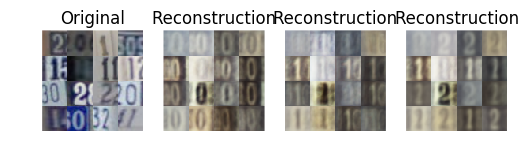

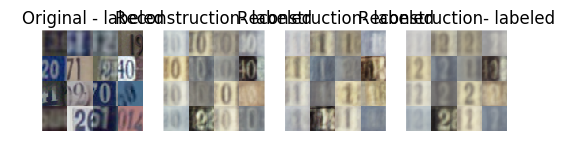

In [36]:
# TRAINING
from IPython.display import Image, display, clear_output
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
plt_vals = []
plt_vals_t = []
samples_processed =0
valid_samples_processed = []
scalarInputs=9
NonScalarInputs=4
out_accum=[0]*(scalarInputs+NonScalarInputs)


try:
    while samples_processed < samples_to_process:
#        print("Number of samples processed: {}".format(samples_processed))
        idxs = np.random.choice(range(x_trai.shape[0]), size=(batch_size), replace=False) 
        x_batch = x_trai[idxs]
        t_batch = t_trai[idxs]
        out = f_train(x_batch, x_train_l, t_train_l)
#        uns_results.add_batch([out,t_batch],batch_size)
  
        mean_factor=min(0.99,samples_processed/batch_size)
        samples_processed += batch_size

#        print(out_accum[i],mean_factor,(1-mean_factor),out[i])

        for i in range(scalarInputs):
            out_accum[i]=out_accum[i]*mean_factor+(1-mean_factor)*out[i]
        
        plt_vals += [out_accum[0]]
        plt_vals_t += [out_accum[4]]

        
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            #size_f(y_eval,LL_rec_eval)
            out = f_eval(x_trai)
            LL_train += [out[0]] 
            #logpx_train += [out[1]]
            #KL_train += [out[2]]
            
            out = f_eval(x_vali)
            LL_valid += [out[0]]
            #logpx_valid += [out[1]]
            #KL_valid += [out[2]]
            
            z_eval = f_z(x_vali)[0]
            #x_sample = f_sample(np.random.normal(size=(100, num_latent_z)).astype('float32'))[0]
            #x_sample = f_sample(np.random.normal(size=(100, num_latent_z * size_up_factor)).astype('float32'))[0]

            clear_output(wait=True)
            print("Samples processed: {} ".format(samples_processed))   
            print("Accumulated outs: {}".format(out_accum,LL_valid[-1]))
            t_plots=4
            
            x_plot=x_vali[np.random.choice(range(x_vali.shape[0]), size=(t_plots*t_plots), replace=False)]
            x_plot_recon = f_reconstruction(x_plot)
            org_plot=tls.plot_svhn(x_plot, 
                                             t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,t2=t_plots,choose_random=False)
            #print(type(org_plot),org_plot)
            _, ax = plt.subplots(1,num_classes+1)
            ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
            ax[0].set_title('Original')
            ax[0].axis('off')
            x_plot_recon[0]*=255
            
            for c in range(num_classes):
                rec_plot=tls.plot_svhn(x_plot_recon[0][np.array(range(t_plots*t_plots))+(t_plots*t_plots)*c,:].astype('int8'),t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,t2=t_plots,choose_random=False)
                ax[c+1].imshow(rec_plot[0], cmap=cmap, interpolation='None')
                ax[c+1].set_title('Reconstruction')
                ax[c+1].axis('off')

                #plt.tight_layout()
            plt.show()
            
            x_plot=x_train_l[np.random.choice(range(x_train_l.shape[0]), size=(t_plots*t_plots), replace=False)]
            x_plot_recon = f_reconstruction(x_plot)
            org_plot=tls.plot_svhn(x_plot, 
                                             t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,t2=t_plots,choose_random=False)
            #print(type(org_plot),org_plot)
            _, ax = plt.subplots(1,num_classes+1)
            ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
            ax[0].set_title('Original - labeled')
            ax[0].axis('off')
            x_plot_recon[0]*=255
            
            for c in range(num_classes):
                rec_plot=tls.plot_svhn(x_plot_recon[0][np.array(range(t_plots*t_plots))+(t_plots*t_plots)*c,:].astype('int8'),t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                             IMG_DEPTH=IMG_DEPTH,t2=t_plots,choose_random=False)
                ax[c+1].imshow(rec_plot[0], cmap=cmap, interpolation='None')
                ax[c+1].set_title('Reconstruction- labeled')
                ax[c+1].axis('off')

                #plt.tight_layout()
            plt.show()
            
except KeyboardInterrupt:
    pass


In [18]:
print(out_accum)
# LL_train,
#                                    LL_train_u,
#                                    LL_train_l,
#                                    certainty_class_u,
#                                    mean_var_u,
#                                    recon_class_same_u,
#                                    certainty_recon_u,
#                                    certainty_class_l,
#                                    mean_var_l,
#                                    prob_recon_u,
#                                    y_train_u,LL_rec_train_u

[-3488.7721091626318, -1931.7213810053715, -1557.0507293099511, 0.99999999845734, -3.7362220633792971, 0.00095455968200484724, 0.95780724983326637, 0.99999994039535112, -3.7300926352500254, 0, 0, 0, 0]


[array(-3501.40380859375, dtype=float32), array(-1944.6575927734375, dtype=float32), array(-1556.746337890625, dtype=float32), array(1.0, dtype=float32), array(-3.72514271736145, dtype=float32), array(0.0), array(0.9438466429710388, dtype=float32), array(0.9999999403953552, dtype=float32), array(-3.7064788341522217, dtype=float32), array([[  7.34090463e-07,   1.00000000e+00,   9.12276592e-15],
       [  3.15856963e-01,   6.84192061e-01,   7.83463203e-24],
       [  7.88173437e-01,   2.11797625e-01,   2.98755670e-28],
       [  3.07574577e-13,   1.00000000e+00,   8.77101538e-29],
       [  1.00000000e+00,   2.52801743e-20,   0.00000000e+00],
       [  9.95007575e-01,   4.96279588e-03,   3.71403129e-23],
       [  9.97196317e-01,   2.75480375e-03,   3.81315417e-33],
       [  9.79581416e-01,   2.03703083e-02,   0.00000000e+00],
       [  4.97276783e-01,   5.02770185e-01,   1.32944416e-19],
       [  7.78230608e-01,   2.21718267e-01,   1.45030289e-29],
       [  3.38497484e-05,   1.000000

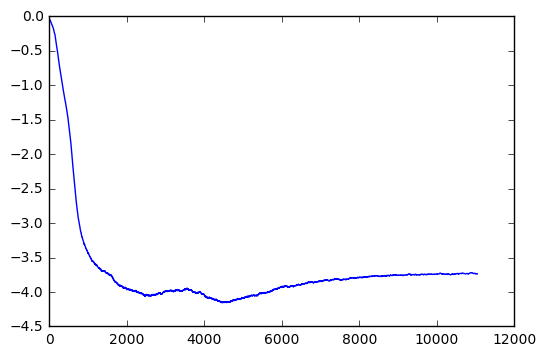

In [20]:
plt.plot(plt_vals_t)

In [21]:
print(np.array(range(100))*num_classes+2)

[  2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 119 122 125 128 131 134 137 140 143 146 149 152 155 158 161
 164 167 170 173 176 179 182 185 188 191 194 197 200 203 206 209 212 215
 218 221 224 227 230 233 236 239 242 245 248 251 254 257 260 263 266 269
 272 275 278 281 284 287 290 293 296 299]
